In [ ]:
pip install kaggle

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chithraanil","key":"31cd3301ede1fabc2c443447368e3134"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

 94% 205M/218M [00:01<00:00, 122MB/s]
100% 218M/218M [00:01<00:00, 119MB/s]


In [ ]:
from glob import glob

In [ ]:
from zipfile import ZipFile ## this is the code to get folders uploaded to colab.after this,just refresh colab,and the files get extracted
##first do upload the file in colab as zip
file_name="cat-and-dog.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

In [ ]:
train_path="/content/training_set/training_set"
test_path="/content/test_set/test_set"
train_path

'/content/training_set/training_set'

In [ ]:
REBUILD_DATA = True 

In [ ]:
class DogsVSCats():
    IMG_SIZE = 50 ##normalized diff images to 50
    CATS = "/content/training_set/training_set/cats/*"
    DOGS = "/content/training_set/training_set/dogs/*"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            #print(label)
            for f in tqdm(glob(label)):
              #print(f)
              if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])   #makes as tensor of tensors(images,onehot label(if cat=0))
                        # do something like print(np.eye(2)[1]), just makes one_hot ,doubt
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)
if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()

              


                      
    ##in the ans,it shows 4006 is thetotalnum,yet 4005 is correct.why?                    


100%|██████████| 4006/4006 [00:04<00:00, 963.88it/s]


Cats: 4000
Dogs: 4005


In [ ]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

8005


In [ ]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50) ##tensor of tensors
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [ ]:
X[0].shape

torch.Size([50, 50])

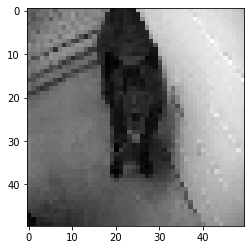

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap="gray")

In [ ]:
#And this is  our convolutional neural network. Full code up to this point:

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [ ]:
#To do this, let's just say we want to use 10% of the data for testing. We can achieve this by doing:

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)


800


In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [ ]:
print(len(train_X), len(test_X))

7205 800


In [ ]:
print(len(train_y), len(test_y))

7205 800


In [ ]:
BATCH_SIZE = 100
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:100] .ans will be 0,100
    #100,200  200,300etc
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad() 

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.31509846448898315


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.24342019855976105


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.20609934628009796


  0%|          | 0/73 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.1527804434299469


100%|██████████| 73/73 [00:29<00:00,  2.49it/s]

Epoch: 4. Loss: 0.10947201400995255


In [ ]:

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)


        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 800/800 [00:01<00:00, 473.43it/s]

Accuracy:  0.654


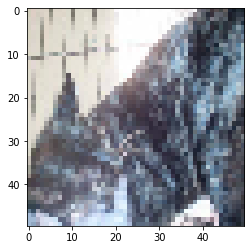

In [ ]:

img = cv2.imread("/content/test_set/test_set/cats/cat.4006.jpg")
img = cv2.resize(img, (50,50))
X = torch.Tensor(img).view(-1,50,50) #either this or above code will work

plt.imshow(img, cmap="gray")


In [ ]:
test_y

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]])